In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing import image


In [2]:
IMAGE_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plates_number",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

NotFoundError: Could not find directory Plates_number

In [9]:
class_names = dataset.class_names

In [10]:
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'pa']

In [12]:
for images_batch , label_batch in dataset.take(1):
    print(images_batch.shape)
    print(label_batch.numpy())

(32, 150, 150, 3)
[ 6  4  5  0  5  7  6  5  9  8 11 11 10  1  6  8 11  8  4  3  8  8 10  9
 11  8  4  0  1  5  4  2]


2023-10-06 22:01:09.454732: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-10-06 22:01:09.455022: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]


In [15]:
for images_batch , label_batch in dataset.take(1):
    print(images_batch[0].shape)
    
    

(150, 150, 3)


2023-10-06 22:02:25.537518: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-10-06 22:02:25.537855: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2033]
	 [[{{node Placeholder/_0}}]]


2023-10-06 22:05:41.062589: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-10-06 22:05:41.062961: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2033]
	 [[{{node Placeholder/_0}}]]


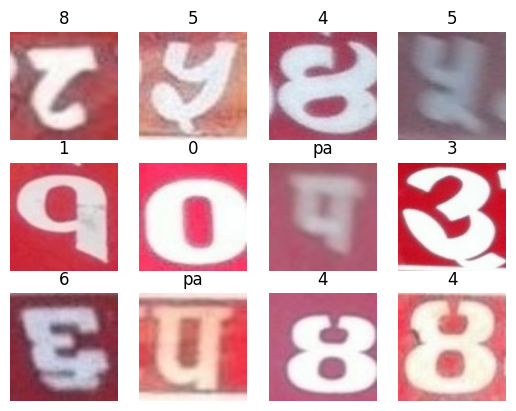

In [19]:
for images_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [20]:
len(dataset)

64

In [21]:
#80% Training
#10% Validation
#10% Testing

In [23]:
train_size = 0.8
len(dataset)*train_size


51.2

In [25]:
train_Dataset = dataset.take(51)
len(train_Dataset)

51

In [26]:
test_Dataset = dataset.skip(54)
len(test_Dataset)

10

In [27]:
val_size = 0.1
val_ds = test_Dataset.take(6)
len(val_ds)

6

In [28]:
test_dss = test_Dataset.skip(6)
len(test_dss)

4

In [33]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

    ds_size = len(ds)

    if shuffle:

        ds = ds. shuffle (shuffle_size, seed=12)

    train_size = int(train_split * ds_size)

    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds. skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [34]:
train_Dataset , val_ds , test_dss = get_dataset_partitions_tf(dataset)

In [38]:
len(train_Dataset)


51

In [39]:
len(val_ds)

6

In [40]:
len(test_dss)

7

In [41]:
train_Dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dss.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [51]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])


In [52]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [68]:
n_classes = 12
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,3,padding="same",activation="relu",input_shape =input_shape ),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(n_classes , activation = "softmax")
])
model.build(input_shape= input_shape)

In [69]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     multiple                  0         
                                                                 
 sequential_1 (Sequential)   (32, 150, 150, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (32, 150, 150, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPooli  (32, 75, 75, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (32, 75, 75, 32)          9248      
                                                                 
 max_pooling2d_17 (MaxPooli  (32, 37, 37, 32)          0         
 ng2D)                                                

In [70]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [73]:
model.fit(
    train_Dataset,
    validation_data = val_ds,
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    verbose = 1
)

Epoch 1/50


2023-10-06 22:48:03.207532: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-10-06 22:48:03.207732: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]


51/51 [==============================] - ETA: 0s - loss: 2.4742 - accuracy: 0.1144

2023-10-06 22:48:12.363057: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2033]
	 [[{{node Placeholder/_0}}]]
2023-10-06 22:48:12.363295: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]


51/51 [==============================] - 10s 161ms/step - loss: 2.4742 - accuracy: 0.1144 - val_loss: 2.4958 - val_accuracy: 0.1094
Epoch 2/50
51/51 [==============================] - 9s 159ms/step - loss: 2.4588 - accuracy: 0.1144 - val_loss: 2.4557 - val_accuracy: 0.1406
Epoch 3/50
51/51 [==============================] - 10s 176ms/step - loss: 2.4466 - accuracy: 0.1249 - val_loss: 2.4827 - val_accuracy: 0.1017
Epoch 4/50
51/51 [==============================] - 10s 172ms/step - loss: 2.3806 - accuracy: 0.1503 - val_loss: 2.3981 - val_accuracy: 0.1356
Epoch 5/50
51/51 [==============================] - 9s 164ms/step - loss: 2.3178 - accuracy: 0.1900 - val_loss: 2.2060 - val_accuracy: 0.2760
Epoch 6/50
51/51 [==============================] - 9s 168ms/step - loss: 2.1682 - accuracy: 0.2598 - val_loss: 2.0534 - val_accuracy: 0.3333
Epoch 7/50
51/51 [==============================] - 9s 164ms/step - loss: 2.0618 - accuracy: 0.3036 - val_loss: 2.0058 - val_accuracy: 0.3333
Epoch 8/50
51/

In [74]:
scores = model.evaluate(test_Dataset)

2023-10-06 22:56:49.091322: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-10-06 22:56:49.091592: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]


10/10 [==============================] - 1s 35ms/step - loss: 0.5093 - accuracy: 0.8459


In [80]:
history

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
IMAGE_SIZE = 150
BATCH_SIZE = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Plates_number',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE)
    batch_size = BATCH_SIZE = 32
)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Plates_number',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE)
    batch_size = BATCH_SIZE 
)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Plates_number',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plates_number",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plates_number",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZ

In [96]:
History

keras.src.callbacks.History

2023-10-06 23:07:47.637928: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2033]
	 [[{{node Placeholder/_0}}]]
2023-10-06 23:07:47.638315: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]


11


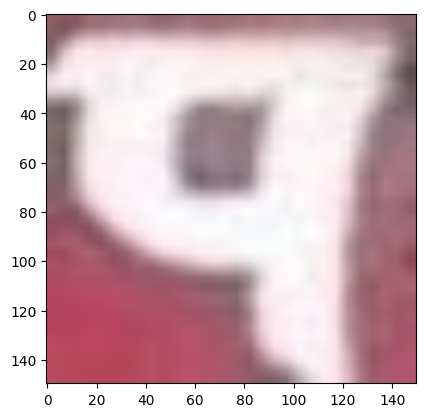

Actual Label:  pa
1/1 [==============================] - 0s 13ms/step
Predicted Label:  pa


In [109]:
import numpy as np 
for images_batch ,label_batch in test_Dataset.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    print(first_label)
    plt.imshow(first_image)
    plt.show()

    
    print("Actual Label: ",class_names[first_label])
    prediction = model.predict(np.array([first_image]))
    predicted_label = np.argmax(prediction)
    print("Predicted Label: ",class_names[predicted_label])

In [122]:
def predic(model ,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    prediction = model.predict(img_array)
    score = tf.nn.softmax(prediction[0])
    print("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)],100*np.max(score)))

    return prediction,np.argmax(score)

2023-10-06 23:16:36.086878: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2033]
	 [[{{node Placeholder/_0}}]]
2023-10-06 23:16:36.087217: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 10ms/step
This image most likely belongs to 1 with a 13.78 percent confidence.
1/1 [==============================] - 0s 10ms/step
This image most likely belongs to 5 with a 12.41 percent confidence.
1/1 [==============================] - 0s 10ms/step
This image most likely belongs to ba with a 19.81 percent confidence.
1/1 [==============================] - 0s 10ms/step
This image most likely belongs to 6 with a 19.63 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to 2 with a 18.83 percent confidence.
1/1 [==============================] - 0s 9ms/step
This image most likely belongs to pa with a 19.57 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to 0 with a 19.80 percent confidence.
1/1 [==============================] - 0s 9ms/step
This image most likely belongs to 2 with a 19.22 percent confidence.
1/1 [===========================

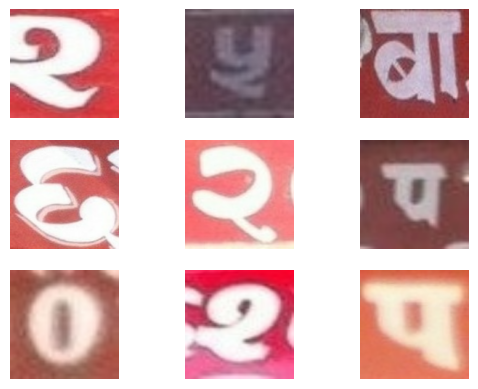

In [126]:
for images, labels in test_Dataset.take(1):
    for i in range(9):
        aisx = plt. subplot (3, 3, i + 1)
        plt. imshow(images[i].numpy() .astype("uint8"))
        predicted_class, confidence = predic(model, images[i]. numpy())
        plt.axis ("off")

In [129]:
model_version = 1.0
model_name = "Plates_number"

model.save(f"../NPV/model/{model_name,model_version}")
model.save('model.h5')
    

INFO:tensorflow:Assets written to: ../NPV/model/('Plates_number', 1.0)/assets


INFO:tensorflow:Assets written to: ../NPV/model/('Plates_number', 1.0)/assets
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
def load_and_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")
    plt.show()


def load_and_predict_class(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    print("\nTHE PREDICTED CLASS IS :- "+predicted_class)
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    
   


image_path = '../NPV/Plates_number/2/1.jpg'


load_and_predict(model, image_path)
load_and_predict_class(model, image_path)

NameError: name 'model' is not defined